<a href="https://colab.research.google.com/github/yoramabbou770/AICourseRoad2/blob/main/DroneExerciseCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

# Replace 'your_file.zip' with the actual file name
zip_file_path = '/content/drone_data-20231210T141638Z-001.zip'

# Replace 'extracted_folder' with the desired extraction path
extraction_path = '/content/extracted_folder/'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified destination folder
    zip_ref.extractall(extraction_path)

# Check if there's only one item in the extraction path (a folder)
extracted_items = os.listdir(extraction_path)
if len(extracted_items) == 1:
    # If there's only one item, update the extraction path
    extraction_path = os.path.join(extraction_path, extracted_items[0])

# Now 'extraction_path' points to the contents of the extracted folder

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf  # Add this line to import TensorFlow


# Define the path to the dataset
dataset_path = "/content/extracted_folder/drone_data/"

processed_images = []
labels = []

# Step 2: Data Preprocessing
for file_name in os.listdir(dataset_path):
    if file_name.endswith(".txt"):  # Assuming label files end with '.txt'
        # Read YOLOv8 label file to extract bounding box information
        with open(os.path.join(dataset_path, file_name), 'r') as label_file:
            # Parse the label file and extract bounding box information
            line = label_file.readline().strip().split()
            _ , x_center, y_center, box_width, box_height = map(float, line)

        # Load the original image
        img_path = os.path.join(dataset_path, file_name.replace(".txt", ".jpg"))
        original_img = Image.open(img_path)

        # Calculate bounding box coordinates
        img_width, img_height = original_img.size
        left = int((x_center - box_width / 2) * img_width)
        top = int((y_center - box_height / 2) * img_height)
        right = int((x_center + box_width / 2) * img_width)
        bottom = int((y_center + box_height / 2) * img_height)

        # Create a new image by cropping the bounding box
        cropped_img = original_img.crop((left, top, right, bottom))

        # Convert the cropped image to grayscale
        grayscale_img = cropped_img.convert("L")

        # Resize the grayscale image to 28x28 using Keras
        resized_img = np.array(grayscale_img.resize((28, 28)))

        # Save the processed image in the list along with the appropriate label (drone)
        processed_images.append(resized_img)
        labels.append(1)  # Assuming label 1 represents a drone

        # Repeat the above steps, but this time take a random crop of the image
        random_left = np.random.randint(0, img_width - 28)
        random_top = np.random.randint(0, img_height - 28)
        random_right = random_left + 28
        random_bottom = random_top + 28

        random_cropped_img = original_img.crop((random_left, random_top, random_right, random_bottom))
        random_cropped_img = random_cropped_img.convert("L")
        random_resized_img = np.array(random_cropped_img.resize((28, 28)))

        # Save the random cropped image in a separate list along with the appropriate label (not a drone)
        processed_images.append(random_resized_img)
        labels.append(0)  # Assuming label 0 represents not a drone

# Step 3: TensorFlow Datasets
X = np.array(processed_images)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Step 4: Build Classifier Model (CNN)
model = keras.Sequential([
    layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 5: Training and Evaluation
model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
163/163 [==============================] - 6s 28ms/step - loss: 0.4269 - accuracy: 0.9349 - val_loss: 0.0692 - val_accuracy: 0.9754
Epoch 2/10
163/163 [==============================] - 4s 27ms/step - loss: 0.0740 - accuracy: 0.9762 - val_loss: 0.0754 - val_accuracy: 0.9800
Epoch 3/10
163/163 [==============================] - 6s 35ms/step - loss: 0.0550 - accuracy: 0.9839 - val_loss: 0.0621 - val_accuracy: 0.9777
Epoch 4/10
163/163 [==============================] - 4s 26ms/step - loss: 0.0357 - accuracy: 0.9885 - val_loss: 0.1402 - val_accuracy: 0.9724
Epoch 5/10
163/163 [==============================] - 4s 27ms/step - loss: 0.0612 - accuracy: 0.9827 - val_loss: 0.0523 - val_accuracy: 0.9862
Epoch 6/10
163/163 [==============================] - 6s 35ms/step - loss: 0.0408 - accuracy: 0.9868 - val_loss: 0.1055 - val_accuracy: 0.9716
Epoch 7/10
163/163 [==============================] - 4s 26ms/step - loss: 0.0518 - accuracy: 0.9860 - val_loss: 0.0526 - val_accuracy: 0.9823

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

51/51 [==============================] - 1s 15ms/step - loss: 0.0778 - accuracy: 0.9834
Test Accuracy: 0.9834152460098267


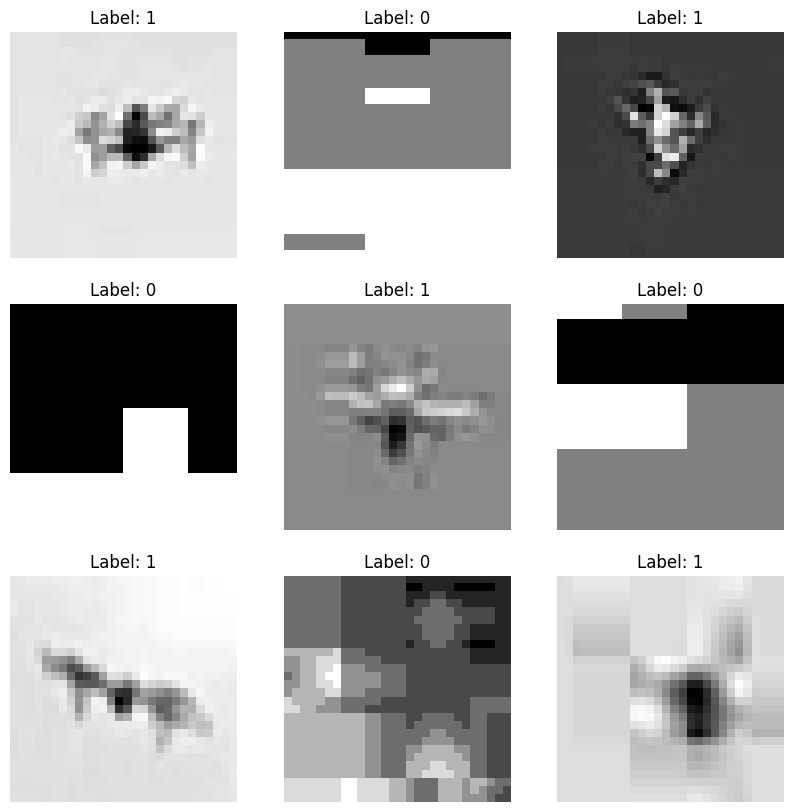

In [ ]:
# Visualize some images from the dataset
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis("off")
plt.show()